In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
def draw_loo_plot(x, y, algorithm, dataset):
    plt.plot(x, y)
    if algorithm == "kNN":
        plt.xlabel('Число ближайших соседей в алгоритме kNN')
    else:
        plt.xlabel('Радиус в алгоритме RadiusNeighbours')
    plt.ylabel('Значение метрики LOO')
    plt.title('Датасет {}'.format(dataset))
    plt.show()

# 1. kNN алгоритм 

In [3]:
def knn(x, data, labels, k):
    dist = lambda y: np.linalg.norm(x-y[0])
    nn, nn_labels = zip(*sorted(zip(data, labels), key=dist)[:k])
    return nn, nn_labels

In [4]:
def most_frequent(a):
    (a, counts) = np.unique(a, return_counts=True)
    idx = np.argmax(counts)
    return a[idx]

In [5]:
def knn_classifier(x, data, labels, k):
    nn, nn_labels = knn(x, data, labels, k)
    return most_frequent(nn_labels)

# 2. Вычисление LOO метрики для алгоритма kNN

In [6]:
def LOO_knn(data, labels, max_k):
    loo = [0 for _ in range(max_k)]
    for i in range(len(data)):
        nn, nn_labels = knn(data[i], data, labels, max_k + 1)
        for k in range(1, max_k + 1):
            label_pred = most_frequent(nn_labels[1:k + 1])
            if label_pred != labels[i]:
                loo[k - 1] += 1
    loo = [x / len(labels) for x in loo]
    return loo

In [7]:
cancer = pd.read_csv('cancer.csv')
cancer_data = cancer.loc[:, '1':'30'].values
cancer_labels = cancer.label.values

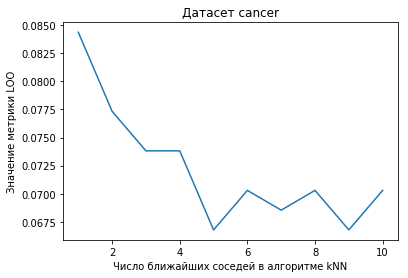

In [8]:
cancer_loo_knn = LOO_knn(cancer_data, cancer_labels, 10)
draw_loo_plot(range(1, 11), cancer_loo_knn, "kNN", "cancer")

In [9]:
spam = pd.read_csv('spam.csv')
spam_data = spam.loc[:, 'word_freq_make':'capital_run_length_total'].values
spam_labels = spam.label.values

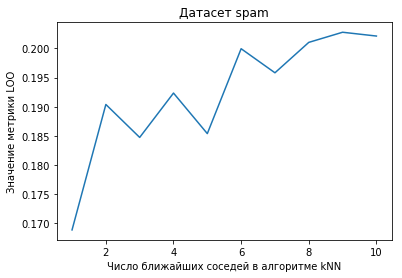

In [10]:
spam_loo_knn = LOO_knn(spam_data, spam_labels, 10)
draw_loo_plot(range(1, 11), spam_loo_knn, "kNN", "spam")

# 3. Алгоритм RadiusNeighbours

In [11]:
def rnn(x, data, labels, r):
    dist = lambda y: np.linalg.norm(x-y)
    nn_dist, nn_labels = zip(*filter(lambda y: y[0] <= r,
                                zip(list(map(dist, data)), labels)))
    return nn_dist, nn_labels

In [12]:
def rnn_classifier(x, data, labels, r):
    nn_dist, nn_labels = rnn(x, data, labels, r)
    if len(nn_dist) == 0:
        return most_frequent(labels)
    return most_frequent(nn_labels)

# 4. Вычисление LOO метрики для алгоритма RadiusNeighbours

In [13]:
def LOO_rnn(data, labels, max_r, n_iter):
    loo = [0 for i in range(n_iter)]
    label_pred = ""
    for i in range(len(data)):
        nn_dist, nn_labels = rnn(data[i], data, labels, max_r)
        nn_dist, nn_labels = zip(*sorted(zip(nn_dist, nn_labels)))
        
        if len(nn_dist) == 1:
            label_pred = most_frequent(labels)
            if label_pred != labels[i]:
                for j in range(n_iter):
                    loo[j] += 1
            continue
                
        border_idx = 0
        
        for j in range(1, n_iter+1):
            r = j * max_r / n_iter
            while (border_idx + 1 < len(nn_dist)) and (nn_dist[border_idx + 1] <= r):
                border_idx += 1
            
            if border_idx == 0:
                label_pred = most_frequent(labels)
            else:
                label_pred = most_frequent(nn_labels[1:border_idx + 1])
                
            if label_pred != labels[i]:
                loo[j - 1] += 1
    loo = [x / len(labels) for x in loo]
    return loo

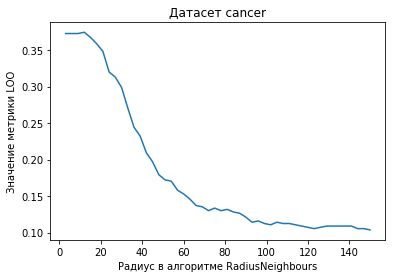

In [14]:
cancer_loo_rnn = LOO_rnn(cancer_data, cancer_labels, 150, 50)
draw_loo_plot(range(3, 151, 3), cancer_loo_rnn, "rNN", "cancer")

In [15]:
print("Лучший радиус в алгоритме RadiusNeighbours для датасета cancer: {}"
     .format((np.argmin(cancer_loo_rnn) + 1) * 150 / 50))

Лучший радиус в алгоритме RadiusNeighbours для датасета cancer: 150.0


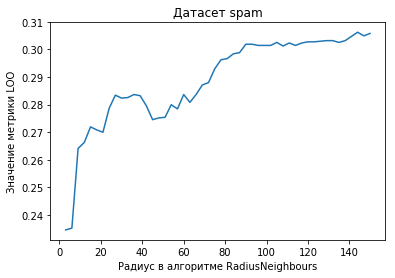

In [16]:
spam_loo_rnn = LOO_rnn(spam_data, spam_labels, 150, 50)
draw_loo_plot(range(3, 151, 3), spam_loo_rnn, "rNN", "spam")

In [17]:
print("Лучший радиус в алгоритме RadiusNeighbours для датасета spam: {}"
      .format((np.argmin(spam_loo_rnn) + 1) * 150 / 50))

Лучший радиус в алгоритме RadiusNeighbours для датасета spam: 3.0


# 5. Нормализация датасета

In [18]:
spam_data_scaled = MinMaxScaler().fit_transform(spam_data)
cancer_data_scaled = MinMaxScaler().fit_transform(cancer_data)

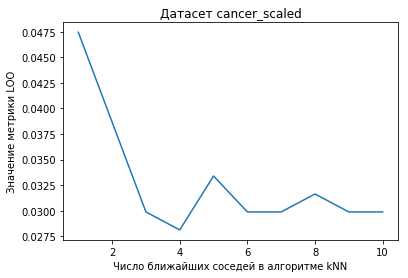

In [19]:
cancer_scaled_loo_knn = LOO_knn(cancer_data_scaled, cancer_labels, 10)
draw_loo_plot(range(1, 11), cancer_scaled_loo_knn, "kNN", "cancer_scaled")

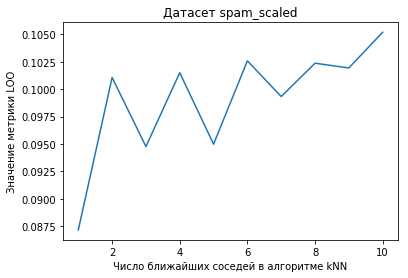

In [20]:
spam_scaled_loo_knn = LOO_knn(spam_data_scaled, spam_labels, 10)
draw_loo_plot(range(1, 11), spam_scaled_loo_knn, "kNN", "spam_scaled")

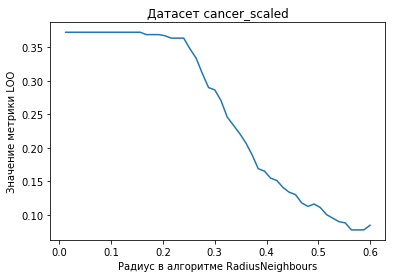

In [21]:
cancer_scaled_loo_rnn = LOO_rnn(cancer_data_scaled, cancer_labels, 0.6, 50)
draw_loo_plot([i*0.6/50 for i in range(1, 51)], cancer_scaled_loo_rnn, "rNN", "cancer_scaled")

In [22]:
print("Лучший радиус в алгоритме RadiusNeighbours для нормализованного датасета cancer: {}"
      .format((np.argmin(cancer_scaled_loo_rnn) + 1) * 0.6 / 50))

Лучший радиус в алгоритме RadiusNeighbours для нормализованного датасета cancer: 0.564


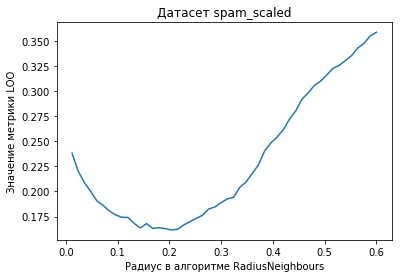

In [23]:
spam_scaled_loo_rnn = LOO_rnn(spam_data_scaled, spam_labels, 0.6, 50)
draw_loo_plot([i*0.6/50 for i in range(1, 51)], spam_scaled_loo_rnn, "rNN", "spam_scaled")

In [24]:
print("Лучший радиус в алгоритме RadiusNeighbours для нормализованного датасета spam: {}"
      .format((np.argmin(spam_scaled_loo_rnn) + 1) * 0.6 / 50))

Лучший радиус в алгоритме RadiusNeighbours для нормализованного датасета spam: 0.204
